In [1]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

2025-07-13 09:46:37.900533: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-13 09:46:37.927755: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-13 09:46:37.927776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-13 09:46:37.928503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-13 09:46:37.932830: I tensorflow/core/platform/cpu_feature_guar

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print(f"gpus: {gpus}")

tf.test.is_built_with_cuda()

gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-07-13 09:46:39.001627: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-13 09:46:39.008765: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-13 09:46:39.011832: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

True

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts

# --- 1. Data Loading and Preparation ---
def load_and_prepare_data(filepath, symbols):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Data file not found at {filepath}. Please ensure the file exists.")
    print(f"Loading data from {filepath}...")
    df = pd.read_csv(filepath, compression='gzip', parse_dates=['timestamp']).set_index('timestamp')
    print("Pivoting data to wide format...")
    df_filtered = df[df['symbol'].isin(symbols)]
    df_pivot = df_filtered.pivot_table(index='timestamp', columns='symbol', values='close')
    df_pivot = df_pivot[symbols]
    df_pivot.fillna(method='ffill', inplace=True)
    df_pivot.dropna(inplace=True)
    df_pivot.columns = [f'{col}_close' for col in df_pivot.columns]
    print(f"Data prepared. Shape: {df_pivot.shape}")
    return df_pivot

# --- 2. Create the Bandit Environment (Correct Implementation) ---
class CryptoTradingEnvironment(py_environment.PyEnvironment):
    def __init__(self, data, lookback_window=10):
        super().__init__()
        self._data = data
        self._lookback = lookback_window
        self._symbols = [col.replace('_close', '') for col in data.columns]
        self._num_cryptos = len(self._symbols)
        
        # Define specs
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=self._num_cryptos * 2 - 1, name='action'
        )
        observation_size = self._num_cryptos * (self._lookback - 1)
        self._observation_spec = array_spec.ArraySpec(
            shape=(observation_size,), dtype=np.float32, name='context'
        )
        
        # Environment state
        self._current_step_index = 0
        self._episode_ended = False

    # Required methods for PyEnvironment
    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _observe(self):
        # The price window for calculating returns is from [t-lookback, t]
        start_idx = self._current_step_index - (self._lookback - 1)
        end_idx = self._current_step_index + 1
        price_window = self._data.iloc[start_idx:end_idx]
        returns = price_window.pct_change().dropna()
        flat_returns = returns.values.flatten()
        return flat_returns.astype(np.float32)

    def _reset(self):
        # Reset to a valid starting point after the lookback window
        self._current_step_index = self._lookback -1
        self._episode_ended = False
        observation = self._observe()
        return ts.restart(observation)

    def _step(self, action):
        if self._episode_ended:
            # The last action ended the episode. Start a new one.
            return self.reset()

        # Calculate reward for the chosen action
        crypto_index = action // 2
        is_buy_action = action % 2 == 0
        column_name = f'{self._symbols[crypto_index]}_close'

        current_price = self._data.iloc[self._current_step_index][column_name]
        next_price = self._data.iloc[self._current_step_index + 1][column_name]
        reward = ((next_price - current_price) / current_price) if is_buy_action else ((current_price - next_price) / current_price)
        
        # Advance the environment state
        self._current_step_index += 1
        
        # Check if the episode has ended
        if self._current_step_index >= len(self._data) - 2:
            self._episode_ended = True
        
        # Return the appropriate TimeStep
        observation = self._observe()
        if self._episode_ended:
            return ts.termination(observation, reward)
        else:
            return ts.transition(observation, reward)

# --- Configuration ---
CRYPTO_NAMES = ['BTC/USDT', 'DOGE/USDT', 'XRP/USDT', 'ETH/USDT', 'SOL/USDT']
DATA_FILEPATH = 'data/ohlcv.csv.gz'
LOOKBACK_WINDOW = 10
NUM_TRAINING_STEPS = 100

# Load data
data = load_and_prepare_data(DATA_FILEPATH, CRYPTO_NAMES)

if NUM_TRAINING_STEPS > len(data) - LOOKBACK_WINDOW - 5:
    NUM_TRAINING_STEPS = len(data) - LOOKBACK_WINDOW - 5
    print(f"\nWarning: Training steps reduced to {NUM_TRAINING_STEPS} to fit available data.")

# --- 3. Instantiate Environment and Agent ---
tf_env = tf_py_environment.TFPyEnvironment(CryptoTradingEnvironment(data, lookback_window=LOOKBACK_WINDOW))

agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec=tf_env.time_step_spec(),
    action_spec=tf_env.action_spec(),
    alpha=1.0,
    dtype=tf.float32
)

# --- 4. Define the Training Loop ---
def train_step(trajectory):
    if not trajectory.is_last():
        time_axised_trajectory = tf.nest.map_structure(lambda t: tf.expand_dims(t, 1), trajectory)
        agent.train(time_axised_trajectory)

training_rewards = []
def collect_reward_observer(trajectory):
    if not trajectory.is_last():
        reward = trajectory.reward.numpy()[0]
        training_rewards.append(reward)

def get_action_name(action):
    crypto_index = action // 2
    action_type = "BUY" if action % 2 == 0 else "SELL"
    return f"{action_type} {CRYPTO_NAMES[crypto_index]}"
    
driver = dynamic_step_driver.DynamicStepDriver(
    env=tf_env,
    policy=agent.policy,
    num_steps=NUM_TRAINING_STEPS,
    observers=[train_step, collect_reward_observer]
)

print(f"\nStarting training for {NUM_TRAINING_STEPS} steps...")
driver.run()
print("Training finished.")

if training_rewards:
    print(f"Total reward earned during training: {sum(training_rewards)}")
    print(f"Average reward per step: {np.mean(training_rewards):.6f}")
else:
    print("No rewards were collected during training.")

# --- 5. Evaluate the Results ---
print("\n--- Evaluation Loop ---")
time_step = tf_env.reset()
cumulative_reward = 0
num_eval_steps = 100
for i in range(num_eval_steps):
    if time_step.is_last():
        print("Evaluation data ended. Resetting.")
        time_step = tf_env.reset()
        
    action_step = agent.policy.action(time_step)
    action = action_step.action.numpy()[0]
    time_step = tf_env.step(action)
    reward = time_step.reward.numpy()[0]
    cumulative_reward += reward
    # print(f"Step {i+1}: Chose action '{get_action_name(action)}', received reward {reward:.6f}")

print(f"\nFinal cumulative reward over last {num_eval_steps} steps: {cumulative_reward:.6f}")

Loading data from data/ohlcv.csv.gz...
Pivoting data to wide format...
Data prepared. Shape: (13094, 5)


/tmp/ipykernel_3236/607417635.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_pivot.fillna(method='ffill', inplace=True)
2025-07-13 09:46:39.428509: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-13 09:46:39.432660: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-13 09:46:39.435737: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NU


Starting training for 100 steps...
Training finished.
Total reward earned during training: 0.11328485360900231
Average reward per step: 0.001133

--- Evaluation Loop ---

Final cumulative reward over last 100 steps: -0.062632


Text(0.5, 0, 'Number of Iterations')

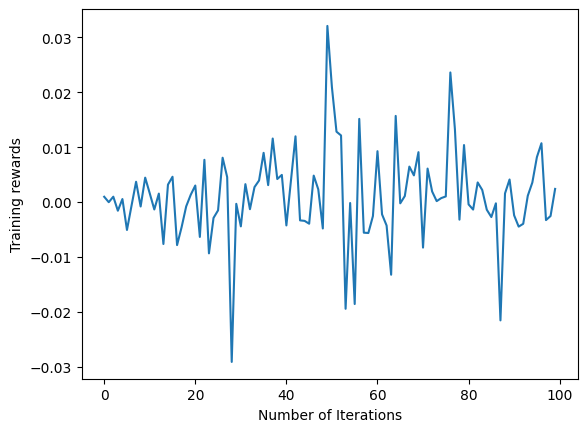

In [ ]:
plt.plot(training_rewards)
plt.ylabel('Training rewards')
plt.xlabel('Number of Iterations')